# Enunciado do trabalho 2 - individual

Com este trabalho pretende-se que os alunos explorem GANs e/ou Autoencoders num problema à escolha do aluno. Há imensos datasets disponíveis para treinar este tipo de redes.

O objectivo principal é explorar as funções de erro, por exemplo na linha do que foi feito na Pix2Pix ou Cycle GAN, e/ou explorar manipulações e combinações de datasets.

O relatório deve ser sucinto, podendo estar incluído no próprio notebook, e deverá conter a descrição da estratégia definida pelos alunos assim como uma discussão/comparação dos resultados obtidos. No caso da comparação esta deverá ser feita com base em resultados publicados por terceiros.

Submissão via BB.

Data final de submissão: 18 de Junho

https://medium.com/@chloelim608/converting-landscapes-into-minecraft-images-with-cyclegan-dd12c284659b

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image
import torch.optim as optim
from tqdm import tqdm

import torchinfo

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.patches import Rectangle

import numpy as np
import time

import os
import pathlib
from PIL import Image
import skimage

import kagglehub

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


c:\Users\Francisco\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Componentes do Modelo

https://github.com/henry32144/cyclegan-notebook/blob/master/pytorch_cycle_gan.ipynb

In [2]:
# Training Configuration
DEVICE = device
LAMBDA_CYCLE = 10.0  # weight for cycle consistency loss
LAMBDA_IDENTITY = 5.0  # weight for identity loss (preserves color composition)
LEARNING_RATE = 2e-4
BETAS = (0.5, 0.999)  # Adam optimizer betas
MAX_EPOCHS = 1000
BATCH_SIZE = 1

# Image Pool Configuration
POOL_SIZE = 50  # Size of image pool for reducing oscillation

# Resume Training Configuration
LOAD_CHECKPOINT = 50  # Set to epoch number to load (e.g., 70), or None to start from beginning
CHECKPOINT_SAVE_INTERVAL = 10  # Save checkpoint every N epochs
SAMPLE_SAVE_INTERVAL = 5  # Save sample images every N epochs

# Early Stopping Configuration
EARLY_STOPPING_PATIENCE = 5  # Number of epochs to wait for improvement
EARLY_STOPPING_MIN_DELTA = 0.00001  # Minimum change to qualify as improvement
EARLY_STOPPING_MONITOR = "cycle_loss"  # Monitor cycle consistency loss

# Create outputs directory if it doesn't exist
os.makedirs("outputs", exist_ok=True)


In [3]:
class ImagePool:
    """
    Image pool to reduce model oscillation by using a history of generated images
    rather than the ones produced by the latest generators.
    Based on the original CycleGAN paper implementation.
    """
    def __init__(self, pool_size=50):
        self.pool_size = pool_size
        self.pool = []

    def query(self, images):
        """
        Returns images from the pool.
        
        Args:
            images: Generated images from the generator
            
        Returns:
            Mixed images from current generation and pool history
        """
        if self.pool_size == 0:
            return images
            
        return_images = []
        
        for image in images:
            image = image.unsqueeze(0)  # Add batch dimension if needed
            
            if len(self.pool) < self.pool_size:
                # Pool not full, add image and return it
                self.pool.append(image.clone())
                return_images.append(image)
            else:
                # Pool is full
                if torch.rand(1) > 0.5:
                    # Return current image without adding to pool
                    return_images.append(image)
                else:
                    # Replace random image in pool and return the replaced one
                    random_id = torch.randint(0, self.pool_size, (1,)).item()
                    temp = self.pool[random_id].clone()
                    self.pool[random_id] = image.clone()
                    return_images.append(temp)
        
        return torch.cat(return_images, dim=0)


def save_sample_images(gen_minecraft, gen_landscape, landscape_batch, minecraft_batch, epoch, save_dir="outputs"):
    """
    Save sample generated images for visual inspection during training.
    Creates comparison grids showing: Real -> Generated -> Reconstructed
    """
    gen_minecraft.eval()
    gen_landscape.eval()
    
    os.makedirs(save_dir, exist_ok=True)
    
    with torch.no_grad():
        # Take first image from each batch
        landscape_sample = landscape_batch[:1].to(DEVICE)
        minecraft_sample = minecraft_batch[:1].to(DEVICE)
        
        # Generate translations
        fake_minecraft = gen_minecraft(landscape_sample)
        fake_landscape = gen_landscape(minecraft_sample)
        
        # Generate cycle reconstructions
        cycle_landscape = gen_landscape(fake_minecraft)
        cycle_minecraft = gen_minecraft(fake_landscape)
        
        # Generate identity images (for identity loss evaluation)
        identity_landscape = gen_landscape(landscape_sample)
        identity_minecraft = gen_minecraft(minecraft_sample)
        
        # Denormalize images for saving (from [-1,1] to [0,1])
        landscape_sample = landscape_sample * 0.5 + 0.5
        minecraft_sample = minecraft_sample * 0.5 + 0.5
        fake_minecraft = fake_minecraft * 0.5 + 0.5
        fake_landscape = fake_landscape * 0.5 + 0.5
        cycle_landscape = cycle_landscape * 0.5 + 0.5
        cycle_minecraft = cycle_minecraft * 0.5 + 0.5
        identity_landscape = identity_landscape * 0.5 + 0.5
        identity_minecraft = identity_minecraft * 0.5 + 0.5
        
        # Create comprehensive comparison grid
        # Row 1: Landscape -> Minecraft -> Reconstructed Landscape
        # Row 2: Minecraft -> Landscape -> Reconstructed Minecraft  
        # Row 3: Identity tests
        comparison = torch.cat([
            torch.cat([landscape_sample, fake_minecraft, cycle_landscape], dim=3),
            torch.cat([minecraft_sample, fake_landscape, cycle_minecraft], dim=3),
            torch.cat([landscape_sample, identity_landscape, minecraft_sample], dim=3)
        ], dim=2)
        
        save_image(comparison, f"{save_dir}/epoch_{epoch}_comparison.png")
    
    gen_minecraft.train()
    gen_landscape.train()


# Download datasets

In [4]:
landscape_dataset = kagglehub.dataset_download(
    "utkarshsaxenadn/landscape-recognition-image-dataset-12k-images"
)
minecraft_dataset = kagglehub.dataset_download(
    "pr1m3r/minecraft-dimensions-screenshots"
)

print(landscape_dataset)
print(minecraft_dataset)

C:\Users\Francisco\.cache\kagglehub\datasets\utkarshsaxenadn\landscape-recognition-image-dataset-12k-images\versions\3
C:\Users\Francisco\.cache\kagglehub\datasets\pr1m3r\minecraft-dimensions-screenshots\versions\3


# Carregar imagens

In [5]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image


# Define transforms
transform = transforms.Compose(
    [
        # transforms.Resize((256, 256)),
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ]
)

landscape_dataset_path = (
    pathlib.Path(landscape_dataset)
    / "Landscape Classification"
    / "Landscape Classification"
    / "Training Data"
)

minecraft_dataset_path = (
    pathlib.Path(minecraft_dataset) / "data" / "nether_comparison_data" / "overworld_sc"
)

print(landscape_dataset_path)
print(minecraft_dataset_path)

# Get image paths
landscape_images = list(landscape_dataset_path.glob("**/*.jpeg"))
minecraft_images = list(minecraft_dataset_path.glob("**/*.png"))

print(f"Found {len(landscape_images)} landscape images")
print(f"Found {len(minecraft_images)} minecraft images")

# Create datasets
landscape_pytorch_dataset = ImageDataset(landscape_images, transform=transform)
minecraft_pytorch_dataset = ImageDataset(minecraft_images, transform=transform)

# Create data loaders
landscape_loader = torch.utils.data.DataLoader(
    landscape_pytorch_dataset, batch_size=BATCH_SIZE, shuffle=True
)
minecraft_loader = torch.utils.data.DataLoader(
    minecraft_pytorch_dataset, batch_size=BATCH_SIZE, shuffle=True
)

print(
    f"Landscape dataset: {len(landscape_pytorch_dataset)} images, {len(landscape_loader)} batches"
)
print(
    f"Minecraft dataset: {len(minecraft_pytorch_dataset)} images, {len(minecraft_loader)} batches"
)


C:\Users\Francisco\.cache\kagglehub\datasets\utkarshsaxenadn\landscape-recognition-image-dataset-12k-images\versions\3\Landscape Classification\Landscape Classification\Training Data
C:\Users\Francisco\.cache\kagglehub\datasets\pr1m3r\minecraft-dimensions-screenshots\versions\3\data\nether_comparison_data\overworld_sc
Found 10000 landscape images
Found 300 minecraft images
Landscape dataset: 10000 images, 10000 batches
Minecraft dataset: 300 images, 300 batches


Sample landscape images:


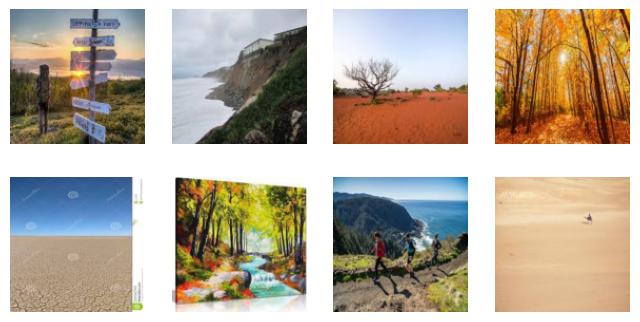

<Figure size 640x480 with 0 Axes>

Sample minecraft images:


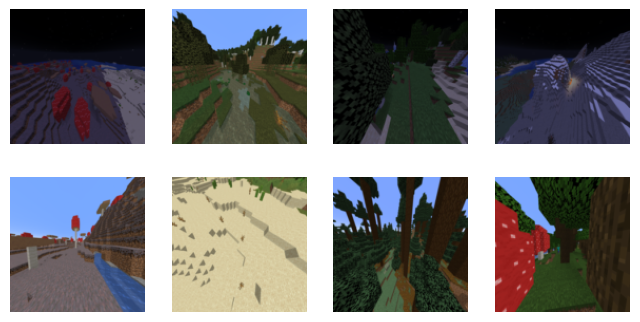

<Figure size 640x480 with 0 Axes>

In [6]:
landscape_images = []
minecraft_images = []

landscape_iter = iter(landscape_loader)
minecraft_iter = iter(minecraft_loader)

# Collect 8 images from each dataset
for i in range(8):
    landscape_images.append(next(landscape_iter))
    minecraft_images.append(next(minecraft_iter))

# Concatenate the images
landscape_batch = torch.cat(landscape_images, dim=0)
minecraft_batch = torch.cat(minecraft_images, dim=0)


def show_images(rows, cols, images):
    width = 2 * rows
    height = 2 * cols

    f, axes = plt.subplots(rows, cols, figsize=(height, width))
    fig = plt.figure()

    for a in range(rows * cols):
        axes.ravel()[a].imshow(
            np.clip(np.transpose(images[a].numpy(), (1, 2, 0)) * 0.5 + 0.5, 0, 1),
            cmap=plt.cm.gray,
        )
        axes.ravel()[a].axis("off")
    fig.tight_layout()
    plt.show()


print("Sample landscape images:")
show_images(2, 4, landscape_batch[:8])

print("Sample minecraft images:")
show_images(2, 4, minecraft_batch[:8])

# Generator (CycleGAN)
https://medium.com/@chilldenaya/cyclegan-introduction-pytorch-implementation-5b53913741ca

In [7]:
class ConvolutionalBlock(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        is_downsampling: bool = True,
        **kwargs,
    ):
        super().__init__()
        if is_downsampling:
            self.conv = nn.Conv2d(
                in_channels, out_channels, padding_mode="reflect", **kwargs
            )
        else:
            self.conv = nn.ConvTranspose2d(in_channels, out_channels, **kwargs)

        self.norm = nn.InstanceNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.norm(x)
        x = self.relu(x)
        return x


class ResidualBlock(nn.Module):
    def __init__(self, channels: int):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1, padding_mode="reflect"),
            nn.InstanceNorm2d(channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1, padding_mode="reflect"),
            nn.InstanceNorm2d(channels),
        )

    def forward(self, x):
        return x + self.block(x)


class Generator(nn.Module):
    def __init__(
        self, img_channels: int, num_features: int = 64, num_residuals: int = 6
    ):
        """
        Generator consists of 2 layers of downsampling/encoding layer,
        followed by 6 residual blocks for 128 x 128 training images
        and then 3 upsampling/decoding layer.

        The network with 6 residual blocks can be written as:
        c7s1-64, d128, d256, R256, R256, R256, R256, R256, R256, u128, u64, and c7s1-3.
        """
        super().__init__()
        self.initial_layer = nn.Sequential(
            nn.Conv2d(
                img_channels,
                num_features,
                kernel_size=7,
                stride=1,
                padding=3,
                padding_mode="reflect",
            ),
            nn.InstanceNorm2d(num_features),
            nn.ReLU(inplace=True),
        )

        self.downsampling_layers = nn.ModuleList(
            [
                ConvolutionalBlock(
                    num_features,
                    num_features * 2,
                    is_downsampling=True,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                ),
                ConvolutionalBlock(
                    num_features * 2,
                    num_features * 4,
                    is_downsampling=True,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                ),
            ]
        )

        self.residual_layers = nn.Sequential(
            *[ResidualBlock(num_features * 4) for _ in range(num_residuals)]
        )

        self.upsampling_layers = nn.ModuleList(
            [
                ConvolutionalBlock(
                    num_features * 4,
                    num_features * 2,
                    is_downsampling=False,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    output_padding=1,
                ),
                ConvolutionalBlock(
                    num_features * 2,
                    num_features * 1,
                    is_downsampling=False,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    output_padding=1,
                ),
            ]
        )

        self.last_layer = nn.Conv2d(
            num_features * 1,
            img_channels,
            kernel_size=7,
            stride=1,
            padding=3,
            padding_mode="reflect",
        )

    def forward(self, x):
        x = self.initial_layer(x)
        for layer in self.downsampling_layers:
            x = layer(x)
        x = self.residual_layers(x)
        for layer in self.upsampling_layers:
            x = layer(x)
        return torch.tanh(self.last_layer(x))

# Discriminator

In [8]:
class ConvInstanceNormLeakyReLUBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()
        self.conv = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=4,
            stride=stride,
            padding=1,
            bias=True,
            padding_mode="reflect",
        )
        self.norm = nn.InstanceNorm2d(out_channels)
        self.relu = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):
        return self.relu(self.norm(self.conv(x)))


class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
        super().__init__()
        self.initial_layer = nn.Sequential(
            nn.Conv2d(
                in_channels,
                features[0],
                kernel_size=4,
                stride=2,
                padding=1,
                padding_mode="reflect",
            ),
            nn.LeakyReLU(0.2, inplace=True),
        )

        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(
                ConvInstanceNormLeakyReLUBlock(
                    in_channels,
                    feature,
                    stride=1 if feature == features[-1] else 2,
                )
            )
            in_channels = feature

        layers.append(
            nn.Conv2d(
                in_channels,
                1,
                kernel_size=4,
                stride=1,
                padding=1,
                padding_mode="reflect",
            )
        )
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = self.initial_layer(x)
        return self.model(x)

# Training

In [9]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""

    def __init__(self, patience=7, min_delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
            min_delta (float): Minimum change in the monitored quantity to qualify as an improvement.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        self.early_stop = False
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True


In [10]:
def find_specific_checkpoint(epoch_num, checkpoint_dir="outputs"):
    checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch_num}.pth")
    
    if os.path.exists(checkpoint_path):
        return checkpoint_path
    else:
        return None


def load_checkpoint(checkpoint_path, models, optimizers, device):
    print(f"Loading checkpoint from: {checkpoint_path}")
    
    try:
        checkpoint = torch.load(checkpoint_path, map_location=device)
        
        # Load model states
        models['gen_minecraft'].load_state_dict(checkpoint['gen_minecraft_state_dict'])
        models['gen_landscape'].load_state_dict(checkpoint['gen_landscape_state_dict'])
        models['disc_minecraft'].load_state_dict(checkpoint['disc_minecraft_state_dict'])
        models['disc_landscape'].load_state_dict(checkpoint['disc_landscape_state_dict'])
        
        # Load optimizer states
        optimizers['opt_gen'].load_state_dict(checkpoint['opt_gen_state_dict'])
        optimizers['opt_disc'].load_state_dict(checkpoint['opt_disc_state_dict'])
        
        # Extract checkpoint information
        start_epoch = checkpoint['epoch'] + 1  # +1 because we want to start from the next epoch
        training_history = checkpoint.get('training_history', {
            'epoch': [],
            'discriminator_loss': [],
            'generator_loss': [],
            'cycle_loss': [],
            'minecraft_real_score': [],
            'minecraft_fake_score': []
        })
        
        early_stopping_state = checkpoint.get('early_stopping_state', {})
        
        print(f"   Successfully loaded checkpoint from epoch {checkpoint['epoch']}")
        print(f"   Will resume training from epoch {start_epoch}")
        print(f"   Training history contains {len(training_history.get('epoch', []))} previous epochs")
        
        return {
            'start_epoch': start_epoch,
            'training_history': training_history,
            'early_stopping_state': early_stopping_state
        }
        
    except Exception as e:
        print(f"Error loading checkpoint: {e}")
        print("Starting training from scratch...")
        return None


In [11]:
def train_fn(
    disc_minecraft,
    disc_landscape,
    gen_landscape,
    gen_minecraft,
    loader,
    opt_disc,
    opt_gen,
    l1,
    mse,
    d_scaler,
    g_scaler,
    epoch,
    minecraft_pool,
    landscape_pool,
):
    minecraft_reals = 0
    minecraft_fakes = 0
    total_d_loss = 0
    total_g_loss = 0
    total_cycle_loss = 0
    total_identity_loss = 0
    num_batches = 0
    
    loop = tqdm(loader, leave=True)

    for idx, (landscape, minecraft) in enumerate(loop):
        landscape = landscape.to(DEVICE)
        minecraft = minecraft.to(DEVICE)

        # Generate fake images
        with torch.autocast(device_type="cuda"):
            fake_minecraft = gen_minecraft(landscape)
            fake_landscape = gen_landscape(minecraft)

        # Apply image pooling to reduce oscillation
        fake_minecraft_pooled = minecraft_pool.query(fake_minecraft.detach())
        fake_landscape_pooled = landscape_pool.query(fake_landscape.detach())

        # Train discriminators for Minecraft and Landscape domains
        with torch.autocast(device_type="cuda"):
            # Discriminator for Minecraft domain
            D_minecraft_real = disc_minecraft(minecraft)
            D_minecraft_fake = disc_minecraft(fake_minecraft_pooled)
            minecraft_reals += D_minecraft_real.mean().item()
            minecraft_fakes += D_minecraft_fake.mean().item()
            
            D_minecraft_real_loss = mse(
                D_minecraft_real, torch.ones_like(D_minecraft_real)
            )
            D_minecraft_fake_loss = mse(
                D_minecraft_fake, torch.zeros_like(D_minecraft_fake)
            )
            D_minecraft_loss = (D_minecraft_real_loss + D_minecraft_fake_loss) * 0.5

            # Discriminator for Landscape domain
            D_landscape_real = disc_landscape(landscape)
            D_landscape_fake = disc_landscape(fake_landscape_pooled)
            D_landscape_real_loss = mse(
                D_landscape_real, torch.ones_like(D_landscape_real)
            )
            D_landscape_fake_loss = mse(
                D_landscape_fake, torch.zeros_like(D_landscape_fake)
            )
            D_landscape_loss = (D_landscape_real_loss + D_landscape_fake_loss) * 0.5

            # Total discriminator loss
            D_loss = D_minecraft_loss + D_landscape_loss

        opt_disc.zero_grad()
        d_scaler.scale(D_loss).backward()
        d_scaler.step(opt_disc)
        d_scaler.update()

        # Train generators for both domains
        with torch.autocast(device_type="cuda"):
            # Adversarial losses for generators (use fresh fake images, not pooled)
            D_minecraft_fake = disc_minecraft(fake_minecraft)
            D_landscape_fake = disc_landscape(fake_landscape)
            loss_G_minecraft = mse(D_minecraft_fake, torch.ones_like(D_minecraft_fake))
            loss_G_landscape = mse(D_landscape_fake, torch.ones_like(D_landscape_fake))

            # Cycle consistency losses
            cycle_landscape = gen_landscape(fake_minecraft)
            cycle_minecraft = gen_minecraft(fake_landscape)
            cycle_landscape_loss = l1(landscape, cycle_landscape)
            cycle_minecraft_loss = l1(minecraft, cycle_minecraft)
            cycle_loss = cycle_landscape_loss + cycle_minecraft_loss

            # Identity losses (preserve color composition)
            # Generator should produce near-identical images when given same domain
            identity_landscape = gen_landscape(landscape)
            identity_minecraft = gen_minecraft(minecraft)
            identity_landscape_loss = l1(landscape, identity_landscape)
            identity_minecraft_loss = l1(minecraft, identity_minecraft)
            identity_loss = identity_landscape_loss + identity_minecraft_loss

            # Total generator loss with weighted components
            G_loss = (
                loss_G_landscape
                + loss_G_minecraft
                + cycle_loss * LAMBDA_CYCLE
                + identity_loss * LAMBDA_IDENTITY
            )

        opt_gen.zero_grad()
        g_scaler.scale(G_loss).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()

        # Accumulate losses for monitoring
        total_d_loss += D_loss.item()
        total_g_loss += G_loss.item()
        total_cycle_loss += cycle_loss.item()
        total_identity_loss += identity_loss.item()
        num_batches += 1

        # Save sample images periodically
        if idx == 0 and epoch % 10 == 0:
            save_image(fake_minecraft * 0.5 + 0.5, f"outputs/minecraft_{epoch}.png")
            save_image(fake_landscape * 0.5 + 0.5, f"outputs/landscape_{epoch}.png")

        loop.set_postfix(
            minecraft_real=minecraft_reals / (idx + 1),
            minecraft_fake=minecraft_fakes / (idx + 1),
            d_loss=total_d_loss / (idx + 1),
            g_loss=total_g_loss / (idx + 1),
            cycle_loss=total_cycle_loss / (idx + 1),
            identity_loss=total_identity_loss / (idx + 1),
        )
    
    # Return average losses for the epoch
    return {
        'discriminator_loss': total_d_loss / num_batches,
        'generator_loss': total_g_loss / num_batches,
        'cycle_loss': total_cycle_loss / num_batches,
        'identity_loss': total_identity_loss / num_batches,
        'minecraft_real_score': minecraft_reals / num_batches,
        'minecraft_fake_score': minecraft_fakes / num_batches,
    }


In [12]:
def create_combined_loader(landscape_loader, minecraft_loader, max_batches=None):
    """
    Create a combined data loader that yields pairs of (landscape, minecraft) batches.
    Since the datasets have different sizes, we'll cycle through the smaller one.
    """
    landscape_iter = iter(landscape_loader)
    minecraft_iter = iter(minecraft_loader)
    
    batches_processed = 0
    
    while True:
        try:
            landscape_batch = next(landscape_iter)
        except StopIteration:
            landscape_iter = iter(landscape_loader)
            landscape_batch = next(landscape_iter)
            
        try:
            minecraft_batch = next(minecraft_iter)
        except StopIteration:
            minecraft_iter = iter(minecraft_loader)
            minecraft_batch = next(minecraft_iter)
            
        # Ensure both batches have the same size
        min_size = min(landscape_batch.size(0), minecraft_batch.size(0))
        landscape_batch = landscape_batch[:min_size]
        minecraft_batch = minecraft_batch[:min_size]
        
        yield landscape_batch, minecraft_batch
        
        batches_processed += 1
        if max_batches and batches_processed >= max_batches:
            break


In [13]:
# Initialize models
disc_minecraft = Discriminator(in_channels=3).to(DEVICE)
disc_landscape = Discriminator(in_channels=3).to(DEVICE)
gen_landscape = Generator(img_channels=3, num_features=64).to(DEVICE)  # Minecraft -> Landscape
gen_minecraft = Generator(img_channels=3, num_features=64).to(DEVICE)  # Landscape -> Minecraft

# Initialize optimizers
opt_disc = optim.Adam(
    list(disc_minecraft.parameters()) + list(disc_landscape.parameters()),
    lr=LEARNING_RATE,
    betas=BETAS,
)
opt_gen = optim.Adam(
    list(gen_landscape.parameters()) + list(gen_minecraft.parameters()),
    lr=LEARNING_RATE,
    betas=BETAS,
)

# Loss functions
L1 = nn.L1Loss()
mse = nn.MSELoss()

# Gradient scalers for mixed precision training
g_scaler = torch.amp.GradScaler()
d_scaler = torch.amp.GradScaler()

print("Models and optimizers initialized successfully!")
print(f"Generator parameters: {sum(p.numel() for p in gen_minecraft.parameters()):,}")
print(f"Discriminator parameters: {sum(p.numel() for p in disc_minecraft.parameters()):,}")


Models and optimizers initialized successfully!
Generator parameters: 7,837,699
Discriminator parameters: 2,764,737


In [283]:
# Initialize training variables
start_epoch = 0
training_history = {
    "epoch": [],
    "discriminator_loss": [],
    "generator_loss": [],
    "cycle_loss": [],
    "identity_loss": [],
    "minecraft_real_score": [],
    "minecraft_fake_score": [],
}

# Initialize image pools for stable training
minecraft_pool = ImagePool(pool_size=POOL_SIZE)
landscape_pool = ImagePool(pool_size=POOL_SIZE)
print(f"Initialized image pools with size: {POOL_SIZE}")

# Initialize early stopping
early_stopping = EarlyStopping(
    patience=EARLY_STOPPING_PATIENCE,
    min_delta=EARLY_STOPPING_MIN_DELTA,
)

# Check if we should load a specific checkpoint
if LOAD_CHECKPOINT is not None:
    print(f"Looking for checkpoint at epoch {LOAD_CHECKPOINT}...")
    checkpoint_path = find_specific_checkpoint(LOAD_CHECKPOINT)

    if checkpoint_path:
        print(f"Found checkpoint: {checkpoint_path}")

        # Create model and optimizer dictionaries for loading
        models = {
            "gen_minecraft": gen_minecraft,
            "gen_landscape": gen_landscape,
            "disc_minecraft": disc_minecraft,
            "disc_landscape": disc_landscape,
        }

        optimizers = {"opt_gen": opt_gen, "opt_disc": opt_disc}

        # Load checkpoint
        checkpoint_info = load_checkpoint(checkpoint_path, models, optimizers, DEVICE)

        if checkpoint_info:
            start_epoch = checkpoint_info["start_epoch"]
            training_history = checkpoint_info["training_history"]

            # Restore early stopping state if available
            early_stopping_state = checkpoint_info["early_stopping_state"]
            if early_stopping_state:
                early_stopping.best_loss = early_stopping_state.get("best_loss")
                early_stopping.counter = early_stopping_state.get("counter", 0)
                print(f"   Restored early stopping state: best_loss={early_stopping.best_loss}, counter={early_stopping.counter}")
    else:
        print(f"Checkpoint for epoch {LOAD_CHECKPOINT} not found. Starting training from scratch.")
else:
    print("No checkpoint specified. Starting fresh training.")

# Main training loop
print(f"\nStarting training from epoch {start_epoch + 1}...")
print(f"Early stopping patience: {EARLY_STOPPING_PATIENCE} epochs")
print(f"Monitoring: {EARLY_STOPPING_MONITOR} with min_delta: {EARLY_STOPPING_MIN_DELTA}")

max_possible_batches = max(len(landscape_loader), len(minecraft_loader))
batches_per_epoch = min(100, max_possible_batches)  # Limit to 100 batches per epoch
print(f"Maximum possible batches: {max_possible_batches}")
print(f"Reduced batches per epoch: {batches_per_epoch}")

for epoch in range(start_epoch, MAX_EPOCHS):
    print(f"\n=== Epoch {epoch + 1}/{MAX_EPOCHS} ===")

    # Create combined data loader for this epoch
    combined_loader = create_combined_loader(landscape_loader, minecraft_loader, max_batches=batches_per_epoch)

    # Train for one epoch
    epoch_losses = train_fn(
        disc_minecraft=disc_minecraft,
        disc_landscape=disc_landscape,
        gen_landscape=gen_landscape,
        gen_minecraft=gen_minecraft,
        loader=combined_loader,
        opt_disc=opt_disc,
        opt_gen=opt_gen,
        l1=L1,
        mse=mse,
        d_scaler=d_scaler,
        g_scaler=g_scaler,
        epoch=epoch,
        minecraft_pool=minecraft_pool,
        landscape_pool=landscape_pool,
    )

    # Store training history
    training_history["epoch"].append(epoch + 1)
    for key, value in epoch_losses.items():
        training_history[key].append(value)

    # Print epoch summary
    print(f"Epoch {epoch + 1} Summary:")
    print(f"  Discriminator Loss: {epoch_losses['discriminator_loss']:.6f}")
    print(f"  Generator Loss: {epoch_losses['generator_loss']:.6f}")
    print(f"  Cycle Loss: {epoch_losses['cycle_loss']:.6f}")
    print(f"  Identity Loss: {epoch_losses['identity_loss']:.6f}")

    # Save sample images for visual inspection
    if (epoch + 1) % SAMPLE_SAVE_INTERVAL == 0:
        print(f"  Saving sample images...")
        landscape_sample = next(iter(landscape_loader))
        minecraft_sample = next(iter(minecraft_loader))
        save_sample_images(gen_minecraft, gen_landscape, landscape_sample, minecraft_sample, epoch + 1)

    # Early stopping check
    monitor_loss = epoch_losses[EARLY_STOPPING_MONITOR]

    early_stopping(monitor_loss)

    # if early_stopping.early_stop:
    #     print(f"\nEarly stopping triggered at epoch {epoch + 1}")
    #     print(f"Best {EARLY_STOPPING_MONITOR}: {early_stopping.best_loss:.6f}")
    #     break

    # Save model checkpoints at specified intervals
    if (epoch + 1) % CHECKPOINT_SAVE_INTERVAL == 0:
        checkpoint = {
            "gen_minecraft_state_dict": gen_minecraft.state_dict(),
            "gen_landscape_state_dict": gen_landscape.state_dict(),
            "disc_minecraft_state_dict": disc_minecraft.state_dict(),
            "disc_landscape_state_dict": disc_landscape.state_dict(),
            "opt_gen_state_dict": opt_gen.state_dict(),
            "opt_disc_state_dict": opt_disc.state_dict(),
            "epoch": epoch,
            "training_history": training_history,
            "early_stopping_state": {
                "best_loss": early_stopping.best_loss,
                "counter": early_stopping.counter,
                "patience": early_stopping.patience,
            },
        }
        torch.save(checkpoint, f"outputs/checkpoint_epoch_{epoch + 1}.pth")
        print(f"Checkpoint saved at epoch {epoch + 1}")

print("Training completed!")

# Plot training history
plt.figure(figsize=(20, 10))

plt.subplot(2, 3, 1)
plt.plot(training_history["epoch"], training_history["discriminator_loss"], label="Discriminator Loss", color="red")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Discriminator Loss Over Time")
plt.legend()
plt.grid(True)

plt.subplot(2, 3, 2)
plt.plot(training_history["epoch"], training_history["generator_loss"], label="Generator Loss", color="blue")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Generator Loss Over Time")
plt.legend()
plt.grid(True)

plt.subplot(2, 3, 3)
plt.plot(training_history["epoch"], training_history["cycle_loss"], label="Cycle Loss", color="green")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Cycle Consistency Loss Over Time")
plt.legend()
plt.grid(True)

plt.subplot(2, 3, 4)
plt.plot(training_history["epoch"], training_history["identity_loss"], label="Identity Loss", color="orange")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Identity Loss Over Time")
plt.legend()
plt.grid(True)

plt.subplot(2, 3, 5)
plt.plot(training_history["epoch"], training_history["minecraft_real_score"], label="Real Score", color="purple")
plt.plot(training_history["epoch"], training_history["minecraft_fake_score"], label="Fake Score", color="pink")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Discriminator Scores Over Time")
plt.legend()
plt.grid(True)

plt.subplot(2, 3, 6)
# Combined losses for comparison
plt.plot(training_history["epoch"], training_history["cycle_loss"], label="Cycle Loss", color="green")
plt.plot(training_history["epoch"], training_history["identity_loss"], label="Identity Loss", color="orange")
total_loss = [c + i for c, i in zip(training_history["cycle_loss"], training_history["identity_loss"])]
plt.plot(training_history["epoch"], total_loss, label="Combined Loss", color="black", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Components Comparison")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print("\nFinal training statistics:")
print(f"Total epochs trained: {len(training_history['epoch'])}")
print(f"Best {EARLY_STOPPING_MONITOR}: {early_stopping.best_loss:.6f}")
if early_stopping.early_stop:
    print(f"Training stopped early due to no improvement for {EARLY_STOPPING_PATIENCE} epochs")

# Print final loss values
if training_history["epoch"]:
    print(f"\nFinal Loss Values:")
    print(f"  Discriminator Loss: {training_history['discriminator_loss'][-1]:.6f}")
    print(f"  Generator Loss: {training_history['generator_loss'][-1]:.6f}")
    print(f"  Cycle Loss: {training_history['cycle_loss'][-1]:.6f}")
    print(f"  Identity Loss: {training_history['identity_loss'][-1]:.6f}")
    print(f"  Image Pool Size: {POOL_SIZE} (for training stability)")

Initialized image pools with size: 50
Looking for checkpoint at epoch 50...
Checkpoint for epoch 50 not found. Starting training from scratch.

Starting training from epoch 1...
Early stopping patience: 5 epochs
Monitoring: cycle_loss with min_delta: 1e-05
Maximum possible batches: 10000
Reduced batches per epoch: 100

=== Epoch 1/1000 ===


100it [00:08, 11.22it/s, cycle_loss=0.769, d_loss=0.668, g_loss=12.6, identity_loss=0.74, minecraft_fake=0.355, minecraft_real=0.647]


Epoch 1 Summary:
  Discriminator Loss: 0.668322
  Generator Loss: 12.618499
  Cycle Loss: 0.769261
  Identity Loss: 0.740090

=== Epoch 2/1000 ===


100it [00:08, 12.03it/s, cycle_loss=0.676, d_loss=0.451, g_loss=11.1, identity_loss=0.641, minecraft_fake=0.285, minecraft_real=0.706]


Epoch 2 Summary:
  Discriminator Loss: 0.451346
  Generator Loss: 11.057855
  Cycle Loss: 0.676393
  Identity Loss: 0.640757

=== Epoch 3/1000 ===


64it [00:05, 12.82it/s, cycle_loss=0.659, d_loss=0.399, g_loss=10.9, identity_loss=0.616, minecraft_fake=0.242, minecraft_real=0.742]

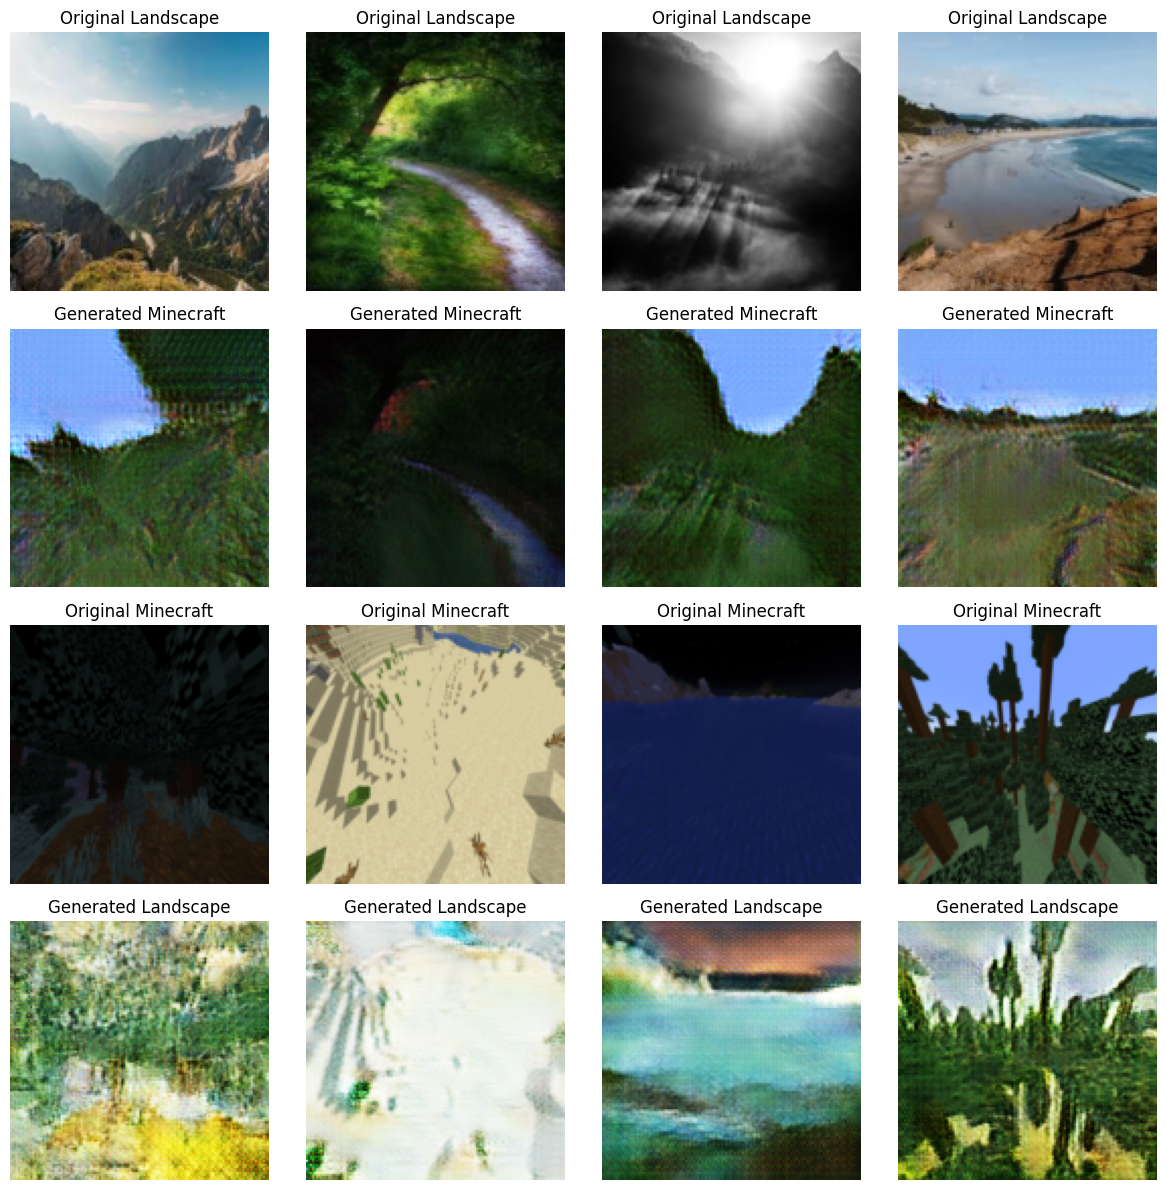

: 

In [ ]:
# Utility function to visualize results
def visualize_results(gen_minecraft, gen_landscape, landscape_batch, minecraft_batch, num_samples=4):
    """
    Visualize the results of the generators on sample batches
    """
    gen_minecraft.eval()
    gen_landscape.eval()
    
    # Collect samples until we have num_samples
    landscape_samples = []
    minecraft_samples = []
    
    landscape_iter = iter(landscape_loader)
    minecraft_iter = iter(minecraft_loader)
    
    while len(landscape_samples) < num_samples:
        try:
            landscape_samples.append(next(landscape_iter))
        except StopIteration:
            landscape_iter = iter(landscape_loader)
            landscape_samples.append(next(landscape_iter))
    
    while len(minecraft_samples) < num_samples:
        try:
            minecraft_samples.append(next(minecraft_iter))
        except StopIteration:
            minecraft_iter = iter(minecraft_loader)
            minecraft_samples.append(next(minecraft_iter))
    
    # Stack the samples into batches
    landscape_batch = torch.cat(landscape_samples, dim=0)
    minecraft_batch = torch.cat(minecraft_samples, dim=0)
    
    with torch.no_grad():
        # Generate fake images
        fake_minecraft = gen_minecraft(landscape_batch.to(DEVICE))
        fake_landscape = gen_landscape(minecraft_batch.to(DEVICE))
        
        # Denormalize for visualization
        landscape_viz = landscape_batch * 0.5 + 0.5
        minecraft_viz = minecraft_batch * 0.5 + 0.5
        fake_minecraft_viz = fake_minecraft.cpu() * 0.5 + 0.5
        fake_landscape_viz = fake_landscape.cpu() * 0.5 + 0.5
        
        # Create visualization
        fig, axes = plt.subplots(4, num_samples, figsize=(num_samples*3, 12))
        
        for i in range(num_samples):
            # Original landscape
            axes[0, i].imshow(np.transpose(landscape_viz[i].numpy(), (1, 2, 0)))
            axes[0, i].set_title('Original Landscape')
            axes[0, i].axis('off')
            
            # Generated minecraft from landscape
            axes[1, i].imshow(np.transpose(fake_minecraft_viz[i].numpy(), (1, 2, 0)))
            axes[1, i].set_title('Generated Minecraft')
            axes[1, i].axis('off')
            
            # Original minecraft
            axes[2, i].imshow(np.transpose(minecraft_viz[i].numpy(), (1, 2, 0)))
            axes[2, i].set_title('Original Minecraft')
            axes[2, i].axis('off')
            
            # Generated landscape from minecraft
            axes[3, i].imshow(np.transpose(fake_landscape_viz[i].numpy(), (1, 2, 0)))
            axes[3, i].set_title('Generated Landscape')
            axes[3, i].axis('off')
        
        plt.tight_layout()
        plt.show()
    
    gen_minecraft.train()
    gen_landscape.train()

# Example usage (uncomment to test):
landscape_sample = next(iter(landscape_loader))
minecraft_sample = next(iter(minecraft_loader))
visualize_results(gen_minecraft, gen_landscape, landscape_sample, minecraft_sample)
